In [1]:
%load_ext jupyter_ai

In [2]:
# 1. Import the necessary functions from edgartools
from edgar import *
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
from tqdm.auto import tqdm
from edgar import Company
from collections import defaultdict
from openai import OpenAI
import os
import ast



import multiprocessing as mp
import swifter
import time
from typing import List, Dict, Any, Tuple
from datetime import datetime
import re
import pdb


In [3]:
# Show more rows
pd.set_option('display.max_rows', 10)  # Change 100 to your desired number

# Show more columns
pd.set_option('display.max_columns', 50)  # Change 50 to your desired number

In [4]:
# 2. Tell the SEC who you are
set_identity("yishaibz@gmail.com")
headers = {'User-Agent': "yishaibz@gmail.com"}


# query llm

In [5]:
def query_llm(prompt: str) -> str:
    """
    Query the LLM via the OpenRouter API using the qwen/qwq-32b model.
    
    Args:
        prompt (str): The prompt to send.
    
    Returns:
        str: The response from the LLM, stripped of extra whitespace.
    """
    client = OpenAI(
        base_url="https://openrouter.ai/api/v1",
        api_key=os.getenv("OPENROUTER_API_KEY"),
    )
    completion = client.chat.completions.create(
        extra_headers={
            "HTTP-Referer": "<YOUR_SITE_URL>",  # Optional: your site URL
            "X-Title": "<YOUR_SITE_NAME>",       # Optional: your site title
        },
        extra_body={},
        #model="qwen/qwq-32b",
        model="qwen/qwen-2.5-7b-instruct",
        messages=[
            {"role": "user", "content": prompt}
        ]
    )
    return completion.choices[0].message.content.strip()

# base data

## paths

In [6]:
sic_inustry_codes_path = r'knowledge/sic_industry_code.csv'
companies_info_path  = r'knowledge/companies_info.csv'
gaap_facts_file_path = r'knowledge/gaap_fact_names.txt'
ifsr_facts_file_path = r'knowledge/ifsr_fact_names.txt'


## base tables

In [7]:
# Read and clean GAAP fact names file

# Define the function to search GAAP or IFRS fact names
def search_fact_names(system: str, factname: str):
    file_path = gaap_facts_file_path if system.lower() == "gaap" else ifsr_facts_file_path
    with open(file_path, "r") as f:
        content = f.read()
    fact_names = [fact.strip() for fact in content.split(",")]
    matches = [fact for fact in fact_names if factname.lower() in fact.lower()]
    print("\n".join(matches))

In [8]:
industries = pd.read_csv(sic_inustry_codes_path)
industries

,SIC Code,Office,Industry Title
0,100,Industrial Applications and Services,AGRICULTURAL PRODUCTION-CROPS
1,200,Industrial Applications and Services,AGRICULTURAL PROD-LIVESTOCK & ANIMAL SPECIALTIES
2,700,Industrial Applications and Services,AGRICULTURAL SERVICES
3,800,Industrial Applications and Services,FORESTRY
4,900,Industrial Applications and Services,"FISHING, HUNTING AND TRAPPING"
...,...,...,...
439,8880,Office of International Corp Fin,AMERICAN DEPOSITARY RECEIPTS
440,8888,Office of International Corp Fin,FOREIGN GOVERNMENTS
441,8900,Office of Trade & Services,"SERVICES-SERVICES, NEC"
442,9721,Office of International Corp Fin,INTERNATIONAL AFFAIRS


In [9]:
industries[industries['Industry Title'].str.contains("agri", case=False, na=False)]

,SIC Code,Office,Industry Title
0,100,Industrial Applications and Services,AGRICULTURAL PRODUCTION-CROPS
1,200,Industrial Applications and Services,AGRICULTURAL PROD-LIVESTOCK & ANIMAL SPECIALTIES
2,700,Industrial Applications and Services,AGRICULTURAL SERVICES
95,2870,Industrial Applications and Services,AGRICULTURAL CHEMICALS


In [10]:
companies_df = pd.read_csv(companies_info_path)
companies_df

,cik_str,ticker,title,industry
0,320193,AAPL,Apple Inc.,3571.0
1,789019,MSFT,MICROSOFT CORP,7372.0
2,1045810,NVDA,NVIDIA CORP,3674.0
3,1018724,AMZN,AMAZON COM INC,5961.0
4,1652044,GOOGL,Alphabet Inc.,7370.0
...,...,...,...,...
9703,1884046,SPKLU,Spark I Acquisition Corp,6770.0
9704,1884046,SPKLW,Spark I Acquisition Corp,6770.0
9705,2019804,HONDW,HCM II Acquisition Corp.,6770.0
9706,2019804,HONDU,HCM II Acquisition Corp.,6770.0


In [11]:
ag_companies = companies_df[companies_df['industry']==2870]
ag_companies

,cik_str,ticker,title,industry
515,1725964,NTR,Nutrien Ltd.,2870.0
768,1324404,CF,"CF Industries Holdings, Inc.",2870.0
1076,941221,ICL,ICL Group Ltd.,2870.0
1097,1285785,MOS,MOSAIC CO,2870.0
1654,825542,SMG,SCOTTS MIRACLE-GRO CO,2870.0
...,...,...,...,...
6011,875729,BNET,BION ENVIRONMENTAL TECHNOLOGIES INC,2870.0
6030,1574565,EVGN,Evogene Ltd.,2870.0
6324,1789192,NITO,"N2OFF, Inc.",2870.0
6517,1680378,SNES,"SenesTech, Inc.",2870.0


# understand sec

sec has a few api endpoints: 

not that cik's need to be 10 digits, with pre filled 0.

submissions, which gets the metadata of all submissions. usually browsed by cik:
```
filingMetadata = requests.get(
    f'https://data.sec.gov/submissions/CIK{cik}.json',
    headers=headers
    )
```

which returns: 
```
dict_keys(['cik', 'entityType', 'sic', 'sicDescription', 'ownerOrg', 'insiderTransactionForOwnerExists', 'insiderTransactionForIssuerExists', 'name', 'tickers', 'exchanges', 'ein', 'description', 'website', 'investorWebsite', 'category', 'fiscalYearEnd', 'stateOfIncorporation', 'stateOfIncorporationDescription', 'addresses', 'phone', 'flags', 'formerNames', 'filings'])
```
 the interesting dict is the fllings dict which contains a entry 'files' which is a dict of all accessions, and a 'recent' entry which is a summary dict of number of fillings. 

 that can be converted to a data frame with the following collumns:

 '''
 files = pd.DataFrame.from_dict(filingMetadata.json()['filings']['recent'])
Index(['accessionNumber', 'filingDate', 'reportDate', 'acceptanceDateTime',
       'act', 'form', 'fileNumber', 'filmNumber', 'items', 'core_type', 'size',
       'isXBRL', 'isInlineXBRL', 'primaryDocument', 'primaryDocDescription'],
      dtype='object')
 '''


the facts api:

```
companyFacts = requests.get(
    f'https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json',
    headers=headers
    )
```

`companyFacts.json().keys() = dict_keys(['cik', 'entityName', 'facts'])`  
where the all the data is in the facts:  
` companyFacts.json()['facts'].keys() = dict_keys(['dei', 'us-gaap'])`  
the **dei dict holds metadata**, exmaple: ` companyFacts.json()['facts']['dei'].keys() = dict_keys(['EntityCommonStockSharesOutstanding', 'EntityPublicFloat'])` but could have other fields. 
and each of these is a further dict:
```
companyFacts.json()['facts']['dei'][
    'EntityCommonStockSharesOutstanding'].keys()

dict_keys(['label', 'description', 'units'])
```

where **units** is the key dict:
`companyFacts.json()['facts']['dei']['EntityCommonStockSharesOutstanding']['units']['shares']` holds a list of dicts, each holding the actual data for a period:

```
{'end': '2025-01-17',
 'val': 15022073000,
 'accn': '0000320193-25-000008',
 'fy': 2025,
 'fp': 'Q1',
 'form': '10-Q',
 'filed': '2025-01-31',
 'frame': 'CY2024Q4I'}
```

and the **gap dict holds specific reporting items**:

`companyFacts.json()['facts']['us-gaap'].keys()` is a massive dict of various line items, eg: 'DeferredTaxAssetsLiabilitiesNet' and 'AvailableForSaleSecuritiesCurrent'.

eg, to get the income for operations: `len(companyFacts.json()['facts']['us-gaap']['OperatingIncomeLoss']['units']['USD'])=213`.

note that the actual data is in the dict 'USD' in the dict 'units'

the helper function `def get_fact_names(company_facts,name):` can be used to quickly get the list of fields with some key word

the **concept** endpoint is similar to the facts api:

```
companyConcept = requests.get(
    (
    f'https://data.sec.gov/api/xbrl/companyconcept/CIK{cik}'
     f'/us-gaap/Assets.json'
    ),
    headers=headers
    )
```

but it holds more meta data on the field: `dict_keys(['cik', 'taxonomy', 'tag', 'label', 'description', 'entityName', 'units'])` 

but the actual values in the units:usd, are the same:   
`len(companyConcept.json()['units']['USD']) = len(companyFacts.json()['facts']['us-gaap']['Assets']['units']['USD']) = 134`

### submissions

In [ ]:
# create request header

# get all companies data
companyTickers = requests.get(
    "https://www.sec.gov/files/company_tickers.json",
    headers=headers
    )

# review response / keys
print(companyTickers.json().keys())

# format response to dictionary and get first key/value
firstEntry = companyTickers.json()['0']

# parse CIK // without leading zeros
directCik = companyTickers.json()['0']['cik_str']

# dictionary to dataframe
companyData = pd.DataFrame.from_dict(companyTickers.json(),
                                     orient='index')

# add leading zeros to CIK to 10 digits
companyData['cik_str'] = companyData['cik_str'].astype(
                           str).str.zfill(10)

In [53]:
cik = companyData.iloc[0,0]
cik

'0000320193'

In [50]:
firstEntry


{'cik_str': 320193, 'ticker': 'AAPL', 'title': 'Apple Inc.'}

In [113]:
company.cik

1285785

In [115]:
# get company specific filing metadata
cik='0001285785'
filingMetadata = requests.get(
    f'https://data.sec.gov/submissions/CIK{cik}.json',
    headers=headers
    )

In [55]:
# review json 
print(filingMetadata.json().keys())

dict_keys(['cik', 'entityType', 'sic', 'sicDescription', 'ownerOrg', 'insiderTransactionForOwnerExists', 'insiderTransactionForIssuerExists', 'name', 'tickers', 'exchanges', 'ein', 'description', 'website', 'investorWebsite', 'category', 'fiscalYearEnd', 'stateOfIncorporation', 'stateOfIncorporationDescription', 'addresses', 'phone', 'flags', 'formerNames', 'filings'])


In [ ]:
filingMetadata.json()['filings']['files']

In [74]:
filingMetadata.json()['insiderTransactionForOwnerExists']

0

In [120]:
pd.DataFrame.from_dict(filingMetadata.json()['filings']['files'])['filingFrom']

0    2004-04-08
Name: filingFrom, dtype: object

In [75]:
files = pd.DataFrame.from_dict(filingMetadata.json()['filings']['recent'])
files

,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,core_type,size,isXBRL,isInlineXBRL,primaryDocument,primaryDocDescription
0,0000320193-25-000036,2025-02-27,2025-02-25,2025-02-27T18:35:41.000Z,,4,,,,4,5739,0,0,xslF345X05/wk-form4_1740699336.xml,FORM 4
1,0000320193-25-000035,2025-02-27,2025-02-25,2025-02-27T18:34:58.000Z,,4,,,,4,5742,0,0,xslF345X05/wk-form4_1740699290.xml,FORM 4
2,0000320193-25-000034,2025-02-27,2025-02-25,2025-02-27T18:34:19.000Z,,4,,,,4,5618,0,0,xslF345X05/wk-form4_1740699250.xml,FORM 4
3,0000320193-25-000033,2025-02-27,2025-02-25,2025-02-27T18:33:20.000Z,,4,,,,4,5765,0,0,xslF345X05/wk-form4_1740699194.xml,FORM 4
4,0000320193-25-000032,2025-02-27,2025-02-25,2025-02-27T18:32:35.000Z,,4,,,,4,5730,0,0,xslF345X05/wk-form4_1740699149.xml,FORM 4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0001193125-14-277160,2014-07-23,2014-06-28,2014-07-23T16:32:48.000Z,34,10-Q,000-10030,14989142,,10-Q,9545320,1,0,d740164d10q.htm,10-Q
996,0001193125-14-275598,2014-07-22,2014-07-22,2014-07-22T16:31:08.000Z,34,8-K,000-10030,14986891,"2.02,9.01",8-K,212673,0,0,d760213d8k.htm,8-K
997,0001181431-14-026992,2014-07-17,2014-07-15,2014-07-17T18:32:50.000Z,,4,,,,4,5423,0,0,xslF345X03/rrd413224.xml,14.07.15 WAGNER FORM 4 RSU
998,0001181431-14-026991,2014-07-17,2014-07-15,2014-07-17T18:32:08.000Z,,3,,,,3,7095,0,0,xslF345X02/rrd413223.xml,14.07.15 WAGNER FORM 3


In [78]:
files.columns

Index(['accessionNumber', 'filingDate', 'reportDate', 'acceptanceDateTime',
       'act', 'form', 'fileNumber', 'filmNumber', 'items', 'core_type', 'size',
       'isXBRL', 'isInlineXBRL', 'primaryDocument', 'primaryDocDescription'],
      dtype='object')

In [ ]:
filingMetadata.json()['filings']['recent'].keys()

### company facts

In [12]:
# get company facts data
cik = '0000857949'
companyFacts = requests.get(
    f'https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json',
    headers=headers
    )

In [102]:
def get_fact_names(company_facts,name):
 return[key for key in company_facts.keys() if re.search(name, key, re.IGNORECASE)]


In [38]:
companyFacts.json()['entityName']

'ENLIGHTIFY, INC.'

In [156]:
companyFacts.json()['facts']['dei'].keys()

dict_keys(['EntityCommonStockSharesOutstanding', 'EntityPublicFloat'])

In [157]:
companyFacts.json()['facts'].keys()

dict_keys(['dei', 'us-gaap'])

In [94]:
companyFacts.json()['facts']['dei'][
    'EntityCommonStockSharesOutstanding']['units']['shares'][-1]

{'end': '2025-01-17',
 'val': 15022073000,
 'accn': '0000320193-25-000008',
 'fy': 2025,
 'fp': 'Q1',
 'form': '10-Q',
 'filed': '2025-01-31',
 'frame': 'CY2024Q4I'}

In [97]:
comp_facts = companyFacts.json()['facts']['us-gaap']

In [159]:
get_fact_names(comp_facts,'')

[]

In [ ]:
def get_fact_values(comp_facts,name,form = '10-K'):
    dict_list = comp_facts['us-gaap'][name]['units']['USD']
    dict_list = [{'value':item['val'],'year':item['fy'],'period':item['fp'] for item in dict_list if form in item['form']]

In [195]:
cga_fil.filter(accession_number='0001144204-13-003152').current()

╭───────────────────────────────────── Filings for Enlightify Inc. [857949] ──────────────────────────────────────╮
│                                                                                                                 │
│   #   Form       Description                                          Filing Date   Accession Number            │
│  ────────────────────────────────────────────────────────────────────────────────────────────────────────       │
│   0   10-K/A     Annual report for public companies                   2013-01-18    0001144204-13-003152        │
│                                                                                                                 │
╰─────────────────────────────── Company filings between 2013-01-18 and 2013-01-18 ───────────────────────────────╯

example:
`fact_list = companyFacts.json()['facts']['us-gaap']['OperatingIncomeLoss']['units']['USD']` yields a list of items. 
and we see that there are several items with the following fields:
```
'start': '2009-07-01',
  'end': '2010-06-30',
  'val': 24926621,
```

but with different accessionds, since the same fact (income for the year 2010 = 24,926,621) may appear in several reports.
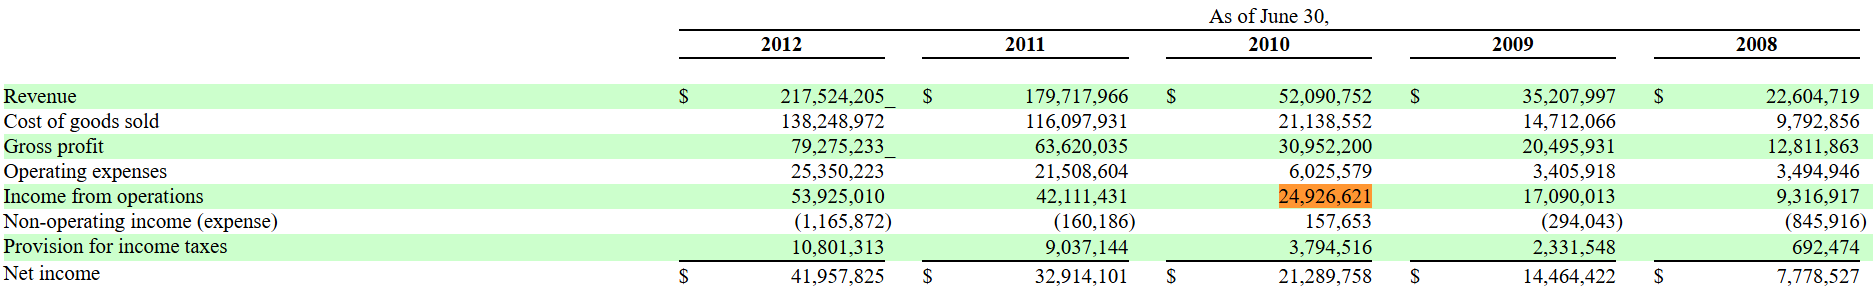
eg, https://www.sec.gov/Archives/edgar/data/857949/000114420412051214/v322271_10k.htm


but a single table may have several frames.

In [28]:
# different amounts of data available per concept
fact_list = companyFacts.json()['facts']['us-gaap']['OperatingIncomeLoss']['units']['USD']
fact_list[:2]

[{'start': '2009-07-01',
  'end': '2010-06-30',
  'val': 24926621,
  'accn': '0001144204-12-052602',
  'fy': 2012,
  'fp': 'FY',
  'form': '10-K/A',
  'filed': '2012-09-24'},
 {'start': '2009-07-01',
  'end': '2010-06-30',
  'val': 24926621,
  'accn': '0001144204-13-003152',
  'fy': 2012,
  'fp': 'FY',
  'form': '10-K/A',
  'filed': '2013-01-18',
  'frame': 'CY2010'}]

In [24]:
form = '10-K'
filtered = [{'value':item['val'],'start':item['start'],'end':item['end'],'year':item['fy'],'period':item['fp']} for item in fact_list if form in item['form']]
filtered[:2]

[{'value': 24926621,
  'start': '2009-07-01',
  'end': '2010-06-30',
  'year': 2012,
  'period': 'FY'},
 {'value': 24926621,
  'start': '2009-07-01',
  'end': '2010-06-30',
  'year': 2012,
  'period': 'FY'}]

In [26]:
data  = pd.DataFrame.from_dict(filtered)

In [121]:
companyFacts.json()['facts']['us-gaap']['Assets'].keys()

dict_keys(['label', 'description', 'units'])

In [31]:
parse_facts_smart(company_facts)

Concept,PeriodLabel,OperatingIncome
0,CY2010,24926621
1,CY2010Q3,9625155
2,CY2010Q4,7872756
3,CY2011,42111431
4,CY2011Q1,12124854
...,...,...
39,FY2019,18804748
40,FY2020,-134172358
41,FY2021,-113747463
42,FY2022,-83798104


### concept

In [123]:
companyConcept = requests.get(
    (
    f'https://data.sec.gov/api/xbrl/companyconcept/CIK{cik}'
     f'/us-gaap/Assets.json'
    ),
    headers=headers
    )

# review data
companyConcept.json().keys()

dict_keys(['cik', 'taxonomy', 'tag', 'label', 'description', 'entityName', 'units'])

In [124]:
len(companyConcept.json()['units']['USD'])

134

In [117]:
companyConcept.json()['units'].keys()

dict_keys(['USD'])

In [ ]:
companyConcept.json()['units']

companyConcept.json()['units']['USD']
companyConcept.json()['units']['USD'][0]

# parse assets from single filing
companyConcept.json()['units']['USD'][0]['val']

# get all filings data 
assetsData = pd.DataFrame.from_dict((
               companyConcept.json()['units']['USD']))

## company parser class

the current approach is very messy. 

since reporting fields change: one years revenues is next years RevenueFromContractWithCustomerExcludingAssessedTax....   

can see exact tab by going to interactive field in flling:



to do:
change reading to focus only on the latest annual reports.
figure out how to identify which fields come from a specific report.
try june or january as the start.

take the peroids reported, and add to series.
then for each report, add only periods for which i dont have values


### terms dict

In [12]:
# mapping terms
#map each term to its irs or gap terms
#cash from operations
#'CashFlowsFromUsedInOperatingActivities'
TERMS = {
    'operating profits': {
        'us-gaap': 'OperatingIncomeLoss',
        'ifrs-full': 'ProfitLossFromOperatingActivities',
        'search':'Operating',
    },
    'gross profit': {
        'us-gaap': 'GrossProfit',
        'ifrs-full': 'GrossProfit',
        'search':r'(income|profit)',
    },
    'revenue': {
        'us-gaap': ['Revenues','SalesRevenueGoodsNet'],
        'ifrs-full': 'Revenues',
    },
    'cost of revenue': {'us-gaap': ['CostOfGoodsSold','CostOfRevenue'],
        'ifrs-full': 'CostOfSales',
                   'search':'cost'
    },

    'sg&a expenses': {
        'us-gaap': 'SellingGeneralAndAdministrativeExpense',
        'ifrs-full': ''
    },
    'operating expenses': {
        'us-gaap': 'OperatingExpenses',
        'ifrs-full': 'OperatingExpenses',
        'search':'Operating',
        
    },
    'interest expenses': {
        'us-gaap': 'InterestExpense',
        'ifrs-full': 'FinanceCosts',
        'search':'Interest'
    },
    'tax expenses': {
        'us-gaap': 'IncomeTaxExpenseBenefit',
        'ifrs-full': 'IncomeTaxExpense',
        'search':'tax'
    },
    'net income': {'us-gaap': ['ProfitLoss','netIncome'],
        'ifrs-full': ['ProfitLoss'],
        'search':r'(income|profit)',
                  },
    
}

COMPOUND_TERMS ={
    'operating margin': ['gross profit', 'revenue', '/'],
}

SYSTEMS = {'us-gaap':'us-gaap','ifrs-full':'ifrs-full'}



### process fillings

In [13]:
import re
from typing import Dict, Any, Optional, Tuple
import pandas as pd
from datetime import datetime

def compute_actual_period(data: Dict[str, Any], period_type: str = "annual") -> Optional[str]:
    """
    Compute the actual reporting period for a fact.
    
    If a 'frame' exists, use it after stripping leading 'CY' and trailing 'I'.
    For annual data, regardless of what quarter the frame indicates, we force a uniform
    annual label based on the year (e.g. "FY2010Q04"). For quarterly data, the frame is
    normalized normally.
    
    If no frame is provided, derive the period from the 'start' and 'end' dates,
    but only if the period spans approximately 365±10 days (annual) or 90±5 days (quarterly).
    
    Returns a string in the format 'FY{year}Q{quarter:02d}', or None if the period is incomplete.
    """
    # Use the authoritative frame if available.
    if data.get('frame'):
        frame = data.get('frame')
        # Remove leading "CY" and trailing "I"
        frame = frame.lstrip("CY").rstrip("I")
        m = re.fullmatch(r"(\d{4})(?:Q(\d{1,2}))?", frame)
        if m:
            year = m.group(1)
            quarter = m.group(2)
            if period_type == "annual":
                # Force an annual label regardless of any quarter in the frame.
                return f"FY{year}"
            else:
                # For quarterly mode, use the provided quarter (pad if needed) or default to Q04.
                if quarter:
                    return f"FY{year}Q{int(quarter):02d}"
                else:
                    return f"FY{year}Q05"
        else:
            return f"FY{frame}"
    
    # If no frame, derive period from the start and end dates.
    try:
        start = pd.to_datetime(data.get('start'))
        end = pd.to_datetime(data.get('end'))
    except Exception:
        return None
    if not start or not end: return None

    # Calculate the total number of days in the period (inclusive)
    days = (end - start).days + 1

    if period_type == "annual":
        # Accept only if the period is roughly 365 days ± 10 days.
        if not (365 - 10 <= days <= 365 + 10):
            return None  # Incomplete annual period; discard.
        # For annual, force the label to be based on the end date's year and default quarter Q04.
        return f"FY{end.year}"
    elif period_type == "monthly":
        # Accept only if the period spans roughly 90 days ± 5 days.
        if not (90 - 5 <= days <= 90 + 5):
            return None  # Incomplete quarterly period; discard.
        # For quarterly data, derive quarter from the end date.
        year = end.year
        month = end.month
        if 1 <= month <= 3:
            quarter = 1
        elif 4 <= month <= 6:
            quarter = 2
        elif 7 <= month <= 9:
            quarter = 3
        elif 10 <= month <= 12:
            quarter = 4
        return f"FY{year}Q{quarter:02d}"
    
    return f"{data.get('start')}_{data.get('end')}"

def parse_normalized_period(period: str) -> Tuple[int, int]:
    """
    Parse a normalized period (e.g., 'FY2010Q03') into a tuple (year, quarter) for sorting.
    """
    m = re.fullmatch(r"FY(\d{4})Q(\d{2})", period)
    if not m:
        raise ValueError(f"Period {period} is not in expected normalized format")
    return int(m.group(1)), int(m.group(2))


In [14]:
class FactRecord:
    def __init__(self, data: Dict[str, Any]):
        self.data = data
        self.start = data.get('start')
        self.end = data.get('end')
        self.value = data.get('val') / 1000000
        self.accn = data.get('accn')
        self.fy = data.get('fy')
        self.fp = data.get('fp')
        self.form = data.get('form')
        self.filed = pd.to_datetime(data.get('filed')) if data.get('filed') else None
        self.frame = data.get('frame')
        self.period: str = ""

    def set_period(self, period_type: str = "annual") -> None:
        self.period = compute_actual_period(self.data, period_type)


    def __repr__(self) -> str:
        return (f"FactRecord(period={self.period}, value={self.value}, "
                f"start={self.start}, end={self.end}, form={self.form}, "
                f"fy={self.fy}, fp={self.fp}, accn={self.accn}, filed={self.filed}, "
                f"frame={self.frame})")

In [15]:
def resolve_duplicates(records: list, fact_name='') -> Dict[str, FactRecord]:
    """
    Group FactRecord instances by their normalized period and resolve duplicates.
    Resolution strategy:
      - Group records by the computed normalized period (using rec.period).
      - If non-amended filings exist, exclude records whose form contains '/A'.
      - Within each group, if one or more records have a non-blank frame, choose
        the record with the latest filing date among them.
      - Otherwise, choose the record with the latest filing date overall.
      - If multiple records in a period have different values, print a warning.
    
    Returns:
        dict: A mapping from normalized period to the chosen FactRecord.
    """
    grouped = {}
    for rec in records:
        if rec.period is None:
            continue
        grouped.setdefault(rec.period, []).append(rec)
    
    resolved = {}
    for period_label, recs in grouped.items():
        # Exclude amended filings if any non-amended record is available.
        primary_recs = [r for r in recs if not re.search(r"/A", r.form)]
        if primary_recs:
            recs = primary_recs

        unique_values = {r.value for r in recs}
        if len(unique_values) > 1:
            print(f"Warning: Different values for {fact_name} in period {period_label}: {unique_values}")

        # Prefer records with a non-blank frame
        with_frame = [r for r in recs if r.frame and r.frame.strip()]
        if with_frame:
            chosen = max(with_frame, key=lambda r: r.filed or datetime.min)
        else:
            chosen = max(recs, key=lambda r: r.filed or datetime.min)
        resolved[period_label] = chosen
    return resolved


### actual class

In [19]:
class CompanyParser:
    def __init__(self, company_facts: Dict[str, Any] = None, cik: str = None, ticker = None, period: str = "annual",years: int = 15):
        """
        Initializes the parser.
        Either a company_facts dict (from the SEC API) or a cik must be provided.
        The period parameter should be 'annual' (for 10-K data) or 'monthly' (for 10-Q data).
        """
        self.period = period.lower()
        if company_facts is not None:
            self.company_facts = company_facts
        elif ticker is not None:
            companies_df = pd.read_csv(companies_info_path)
            cik = companies_df.query("ticker == @ticker")['cik_str'].iloc[0]
            self.get_facts_from_cik(cik)
        elif cik is not None:
            self.get_facts_from_cik(cik)
        else:
            raise ValueError("Either a company facts dictionary or a CIK must be provided.")
        
        self.cik = str(self.company_facts['cik']).zfill(10)
        self.system =  [key for key in self.company_facts["facts"].keys() if key in SYSTEMS.keys()][0]
        self.name = self.company_facts['entityName']
        self.years = years
        self.table = None


        # Determine company founding year and adjust self.years if needed.
        founding_year = self.determine_founding_year()
        current_year = datetime.now().year
        self.max_years = current_year - founding_year + 1
        if self.max_years < self.years:
            print(f"Adjusting years from {self.years} to {self.max_years} based on founding year {founding_year}.")
            self.years = self.max_years


    def get_facts_from_cik(self,cik):
            cik = str(cik).zfill(10)
            url = f"https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json"
            headers = {'User-Agent': 'yishaibz@gmail.com'}
            response = requests.get(url, headers=headers)
            response.raise_for_status()
            self.company_facts = response.json()

    def determine_founding_year(self) -> int:
        headers = {'User-Agent': 'yishaibz@gmail.com'}
        url = f'https://data.sec.gov/submissions/CIK{self.cik}.json'
        try:
            filingMetadata = requests.get(url, headers=headers)
            filingMetadata.raise_for_status()
            filing_df = pd.DataFrame.from_dict(filingMetadata.json()['filings']['files'])
            if 'filingFrom' in filing_df.columns:
                date_series = filing_df['filingFrom']
            elif 'filingDate' in filing_df.columns:
                date_series = filing_df['filingDate']
            else:
                raise KeyError("Neither 'filingFrom' nor 'filingDate' found in filing metadata.")
            earliest_date = pd.to_datetime(date_series.min())
            return earliest_date.year
        except Exception as e:
            print(f"Filing metadata lookup failed: {e}. Falling back to scanning fact data.")
            # Fallback: scan all fact records for the earliest 'start' date.
            earliest = None
            facts = self.company_facts.get('facts', {}).get(self.system, {})
            for fact in facts.values():
                for record in fact.get("units", {}).get("USD", []):
                    try:
                        start = pd.to_datetime(record.get("start"))
                        if earliest is None or start < earliest:
                            earliest = start
                    except Exception:
                        continue
            if earliest is not None:
                return earliest.year
            else:
                # If nothing is found, default to the current year.
                return datetime.now().year
        
    def get_fact_names(self,name):
        return [key for key in self.company_facts['facts'][self.system].keys() if re.search(name, key, re.IGNORECASE)]

    def fallback_get_fact_field(self, fact_name: str) -> str:
        """
        Backup method to determine the best field name if none of the standard fallbacks work.
        The method prints the chosen field and returns it.
        
        Args: fact_name (str): The fact name for which a field is needed.
        Returns: str: The chosen field name from the candidate list.
        Raises: ValueError: If no candidate fields are found.
        """
        candidate_fields = []
        # Try to use the 'search' key from TERMS if available.
        if fact_name in TERMS and isinstance(TERMS[fact_name], dict) and 'search' in TERMS[fact_name]:
            candidate_fields = self.get_fact_names(TERMS[fact_name]['search'])
        else:
            # Fall back: use the fact_name itself as a search term.
            candidate_fields = self.get_fact_names(fact_name)
        
        if not candidate_fields:
            raise ValueError(f"No candidate fields found for fact '{fact_name}'.")
        
        prompt = (
            f"Help me find the field name from the following list that is most likely to represent "
            f"'{fact_name}' in the reporting of a company. Please respond with a list containing only the string names of the top 5 most likely fields, with the most likely being first. example format for answer: ['mostlikelyfieldname','secondmosltlikelyfieldname',...]\n\n"
            f"Candidates: {candidate_fields}"
        )
        
        chosen_field = query_llm(prompt)
        print(f"Found field '{chosen_field}' for fact '{fact_name}'.")
        return chosen_field



    

    def simple_get_fact(self, candidate: str, period: str = None) -> pd.Series:
        """
        Parses and returns the fact series for a single candidate field name.
        """
        period_type = period.lower() if period is not None else self.period
        try:
            fact_list = self.company_facts["facts"][self.system][candidate]["units"]["USD"]
        except KeyError:
            raise KeyError(f"Candidate '{candidate}' not found in company facts.")
        
        records = []
        for item in fact_list:
            form = item.get("form", "")
            if period_type == "annual" and not re.match(r"(10-K|10-K/A|20-F|40-F)$", form):
                continue
            if period_type == "monthly" and not re.match(r"10-Q(/A)?$", form):
                continue
            rec = FactRecord(item)
            rec.set_period(period_type)
            if rec.period is not None:
                records.append(rec)
        if not records:
            raise ValueError(f"No valid records for candidate '{candidate}'.")
        resolved = resolve_duplicates(records, fact_name=candidate)
        fact_values = {p: rec.value for p, rec in resolved.items()}
        try:
            sorted_keys = sorted(fact_values.keys(), key=lambda x: parse_normalized_period(x))
        except Exception:
            sorted_keys = list(fact_values.keys())
        return pd.Series({k: fact_values[k] for k in sorted_keys}, name=candidate)

    def reconcile_fact(self, series_list: list) -> pd.Series:
        """
        Given a list of partial fact series, remove duplicates and combine them.
        The simplest strategy here is to use pandas' combine_first to fill in missing values.
        """
        pdb.set_trace()
        unique_series = []
        for s in series_list:
            if not any(s.equals(u) for u in unique_series):
                unique_series.append(s)
        if not unique_series:
            raise ValueError("No series to reconcile.")
        merged = unique_series[0]
        for s in unique_series[1:]:
            merged = merged.combine_first(s)
        return merged



    def robust_fact_getter(self, fact_name: str, period: str = None) -> pd.Series:
        """
        Attempts to retrieve a complete fact series for a given financial concept.
        
        It builds a candidate list (using TERMS if available) and repeatedly pops a candidate,
        calling simple_get_fact on it. If a candidate returns a series with at least the required
        number of periods (self.years for annual or self.years*4 for quarterly), it returns that series.
        
        Otherwise, it stores partial series. If no candidate yields a long enough series, it calls
        fallback_get_fact_field to obtain additional candidate names (which are appended to the candidate list).
        
        If multiple partial series were gathered, reconcile_fact is called to attempt to merge them.

        currently ignores compound facts!!
        """
        period_type = period.lower() if period is not None else self.period
        # Build initial candidate list from TERMS if available.
        if fact_name in TERMS:
            candidate = TERMS[fact_name][self.system]
            if not isinstance(candidate, list):
                candidates = [candidate]
            else:
                candidates = candidate.copy()
        else:
            candidates = [fact_name]
        
        # Set required length based on period type.
        required_length = self.years if period_type == "annual" else self.years * 4
        
        collected_series = []
        tried_llm = False
        
        while candidates:
            pdb.set_trace()
            candidate = candidates.pop(0)
            try:
                
                series = self.simple_get_fact(candidate, period)
            except (KeyError, ValueError):
                continue
            # If this candidate gives a series with sufficient periods, return it immediately.
            if len(series) >= required_length:
                return series
            else:
                collected_series.append(series)
            # If candidates are exhausted, try LLM fallback to get new candidate names.
            if not candidates and not tried_llm:
                llm_response = self.fallback_get_fact_field(fact_name)
                # Expecting a comma-separated list from the LLM.
                try:
                    new_candidates = ast.literal_eval(llm_response)
                except Exception:
                    new_candidates = [s.strip(" '\"") for s in llm_response.split(",") if s.strip()]
                # Append only new candidate names not already seen.
                for cand in new_candidates:
                    if cand not in candidates:
                        candidates.append(cand)
                pdb.set_trace()
                tried_llm= True
        # If no candidate gave a series long enough, try to reconcile partial results.
        if collected_series:
            merged = self.reconcile_fact(collected_series)
            if len(merged) >= required_length:
                return merged
            else:
                print("Reconciled series is still shorter than required.")
                return merged
        raise ValueError(f"No valid records found for fact '{fact_name}' with period type '{period_type}'.")
   
    
    def get_fact(self, fact_name: str, period: str = None) -> pd.Series:
        """
        The public method to retrieve a fact series.
        
        For robust parsing it simply calls robust_fact_getter.
        """
        return self.robust_fact_getter(fact_name, period)
    
    def old_get_fact(self, fact_name: str, period: str = None, tried_fallback = False) -> pd.Series:
        """
        Extracts and deduplicates a fact from the company facts.
        Returns a pandas Series indexed by the normalized period (format: FYYYYYQQ).
    
        This method supports using a list of possible fact names as fallbacks. For example,
        if the TERMS dictionary is defined as:
          'costs of revenue': {'us-gaap': ['CostOfGoodsSold', 'CostOfRevenue']}
        then this method will try 'CostOfGoodsSold' first; if no valid data is found,
        it will then try 'CostOfRevenue'.
    
        Args:
            fact_name (str): The fact name to lookup.
            period (str, optional): The period type to use ("annual" or "monthly"). Defaults to self.period.
    
        Returns:
            pd.Series: A pandas Series with the fact values indexed by period.
        """
        period_type = period.lower() if period is not None else self.period
        if fact_name in COMPOUND_TERMS.keys():
            compound_def = COMPOUND_TERMS.get(fact_name.lower())
            if compound_def is None or not isinstance(compound_def, (list, tuple)) or len(compound_def) != 3:
                raise KeyError(f"Compound fact definition for '{compound_term}' not found or is invalid.")
            return self.get_compound_fact(fact_name, table=self.table)
    
        # Determine candidate fact names: if fact_name is defined in TERMS,
        # then use the mapped value(s) for the current system.
        if fact_name in TERMS:
            candidate = TERMS[fact_name][self.system]
            # If the candidate is not a list, convert it into a list for unified processing.
            if not isinstance(candidate, list):
                candidate_facts = [candidate]
            else:
                candidate_facts = candidate
        else:
            candidate_facts = [fact_name]
    
        # Loop over candidate fact names until valid records are found.
        for candidate in candidate_facts:
            try:
                fact_list = self.company_facts["facts"][self.system][candidate]["units"]["USD"]
            except KeyError:
                continue  # Try the next candidate if the current one is not found.
            
            records = []
            for item in fact_list:
                form = item.get("form", "")
                # For annual data, accept forms like "10-K", "10-K/A", "20-F", or "40-F"
                if period_type == "annual" and not re.match(r"(10-K|10-K|20-F|40-F)$", form):
                    continue
                # For quarterly data (here using "monthly" mode), accept "10-Q" or "10-Q/A"
                if period_type == "monthly" and not re.match(r"10-Q(/A)?$", form):
                    continue
                rec = FactRecord(item)
                rec.set_period(period_type)
                if rec.period is not None:
                    records.append(rec)
            
            # If we found any valid records for this candidate, proceed.
            if records:
                resolved = resolve_duplicates(records,fact_name = candidate)
                fact_values = {period_label: rec.value for period_label, rec in resolved.items()}
                try:
                    sorted_keys = sorted(fact_values.keys(), key=lambda x: parse_normalized_period(x))
                except Exception:
                    sorted_keys = list(fact_values.keys())
                # Name the resulting series with the original fact name (or you may choose candidate)
                series = pd.Series({k: fact_values[k] for k in sorted_keys}, name=fact_name)
                if len(series) < self.years - 2: continue
                return series

        # If none of the candidates yield valid records, raise an error.
        if not tried_fallback: 
            new_fact_name = self.fallback_get_fact_field(fact_name)
            return self.get_fact(new_fact_name,tried_fallback=True)
        
        raise ValueError(f"No valid records found for fact '{fact_name}' (tried candidates: {candidate_facts}) with period type '{period_type}'.")

        

    def get_compound_fact(self, compound_term: str, table: pd.DataFrame = None) -> pd.Series:
        """
        Calculate a compound fact based on two underlying facts and an arithmetic operator.
        
        For example, if the TERMS dictionary is extended with:
            COMPOUND_TERMS['operating margin'] = ['gross profit', 'revenue', '/']
        then get_compound_fact('operating margin') will:
          - retrieve the 'gross profit' and 'revenue' series,
          - align them on their reporting periods,
          - compute operating margin as gross profit divided by revenue.
        
        Before retrieving each underlying fact, this method checks if self.table (or the passed table)
        already contains the necessary column. If so, it reuses that data.
        
        Args:
            compound_term (str): The compound fact name.
            table (pd.DataFrame, optional): A DataFrame that may already contain underlying fact data.
        
        Returns:
            pd.Series: The computed compound fact series.
        """
        compound_def = COMPOUND_TERMS.get(compound_term.lower())
        if compound_def is None or not isinstance(compound_def, (list, tuple)) or len(compound_def) != 3:
            raise KeyError(f"Compound fact definition for '{compound_term}' not found or is invalid.")
        
        fact1, fact2, op = compound_def

        # Use the underlying fact if already in the provided table.
        if table is not None and fact1 in table.columns:
            series1 = table[fact1]
        else:
            series1 = self.get_fact(fact1)
        
        if table is not None and fact2 in table.columns:
            series2 = table[fact2]
        else:
            series2 = self.get_fact(fact2)
        
        # Align the two series.
        df = pd.concat([series1, series2], axis=1, join='outer')
        df.columns = ['fact1', 'fact2']
        
        # Compute compound fact.
        if op == '/':
            df[compound_term] = df['fact1'] / df['fact2'].replace({0: pd.NA})
        elif op == '*':
            df[compound_term] = df['fact1'] * df['fact2']
        elif op == '+':
            df[compound_term] = df['fact1'] + df['fact2']
        elif op == '-':
            df[compound_term] = df['fact1'] - df['fact2']
        else:
            raise ValueError(f"Operator '{op}' not supported for compound fact computation.")
        
        return df[compound_term]
        
    def get_table(self, facts: list = None, years: int = 15, all=False) -> pd.DataFrame:
        """
        Create a table of key metrics over a series of reporting periods.

        Args:
            facts (list, optional): List of fact names to retrieve. If None,
                                    a fallback list of ['gross profit', 'revenue'] is used.
            years (int, optional): Number of years to span. Default is 15.

        Returns:
            pd.DataFrame: A DataFrame indexed by period (e.g. FYYYYY or FYYYYYQ01) with columns for each fact.
        """
        temp = self.years
        self.years = years
        if facts is None:
            facts = ['gross profit', 'revenue', 'operating margin','net income']
        if all: 
            self.years = 0
            facts=list(self.company_facts["facts"][self.system].keys())
            
        self.table=None
        # Fallback facts list if none provided.

        
        # Determine current year (could also be adjusted to use a known start/end from data)
        current_year = datetime.now().year
        
        # Generate period series based on the parser's period type.
        # If annual, periods are "FY{year}".
        # If not (assuming quarterly, using the "monthly" flag from our code), periods are "FY{year}Q01".
        if self.period == "annual":
            # Generate a list of annual periods from (current_year - years) to current_year.
            periods = [f"FY{y}" for y in range(current_year - years, current_year + 1)]
        else:
            # For quarterly data (using our 'monthly' mode), we generate periods with quarter Q01.
            periods = [f"FY{y}Q01" for y in range(current_year - years, current_year + 1)]
        
        # Create an initial DataFrame with the periods as the index.
        self.table = pd.DataFrame(index=periods)
        
        # For each requested fact, get its series and join it to the table.
        for fact in facts:
            try:
                # get_fact returns a Series indexed by period
                series = self.get_fact(fact,tried_fallback=all)
                # Rename the series to the fact name and join with our table index.
                self.table = self.table.join(series.rename(fact), how='left')
            except KeyError as e:
                print(f"Warning: Fact '{fact}' not found in the company facts. Error: {e}")
            except ValueError as e:
                continue
        
        # Drop rows where all fact columns are NaN.
        table_clean = self.table.dropna(how='all')
        
        # Warn if there is missing data in any field after dropping empty rows.
        if table_clean.isna().any().any():
            print("Warning: Missing data in some fields after dropping empty rows.")
        
        return table_clean

In [23]:
parser = CompanyParser(ticker ='MOS', period='annual')
parser.name, parser.system

('Mosaic Co', 'us-gaap')

still very weird why duplicate. need to find the fact for the period and resolve

In [25]:
parser.simple_get_fact('SalesRevenueGoodsNet')

FY2008    10298.0
FY2010     6759.1
FY2009     6759.1
FY2011    11107.8
FY2012     9974.1
FY2013     9974.1
FY2014     9055.8
FY2015     8895.3
FY2016     7162.8
FY2017     7409.4
Name: SalesRevenueGoodsNet, dtype: float64

In [27]:
parser.simple_get_fact('Revenues')

FY2018     9587.3
FY2019     8906.3
FY2020     8681.7
FY2021    12357.4
FY2022    19125.2
FY2023    13696.1
FY2024    11122.8
Name: Revenues, dtype: float64

In [234]:
ag_companies

,cik_str,ticker,title,industry
515,1725964,NTR,Nutrien Ltd.,2870.0
768,1324404,CF,"CF Industries Holdings, Inc.",2870.0
1076,941221,ICL,ICL Group Ltd.,2870.0
1097,1285785,MOS,MOSAIC CO,2870.0
1654,825542,SMG,SCOTTS MIRACLE-GRO CO,2870.0
...,...,...,...,...
6011,875729,BNET,BION ENVIRONMENTAL TECHNOLOGIES INC,2870.0
6030,1574565,EVGN,Evogene Ltd.,2870.0
6324,1789192,NITO,"N2OFF, Inc.",2870.0
6517,1680378,SNES,"SenesTech, Inc.",2870.0


In [ ]:
table = parser.get_table(years=15, all=True)

In [112]:
table.to_csv('mos_table.csv')

In [110]:
table

,AccountsPayableCurrent,AccountsPayableFairValueDisclosure,AccountsReceivableFairValueDisclosure,AccountsReceivableGross,AccountsReceivableGrossCurrent,AccountsReceivableGrossNoncurrent,AccountsReceivableRelatedPartiesCurrent,AccretionExpense,AccrualForEnvironmentalLossContingencies,AccrualForTaxesOtherThanIncomeTaxesCurrent,AccruedIncomeTaxes,AccruedIncomeTaxesCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossDefinedBenefitPensionAndOtherPostretirementPlansNetOfTax,AccumulatedOtherComprehensiveIncomeLossForeignCurrencyTranslationAdjustmentNetOfTax,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalCollateralAggregateFairValue,AdditionalPaidInCapitalCommonStock,AdjustmentsNoncashItemsToReconcileNetIncomeLossToCashProvidedByUsedInOperatingActivitiesOther,AdjustmentsToAdditionalPaidInCapitalOther,AdjustmentsToAdditionalPaidInCapitalShareBasedCompensationRestrictedStockUnitsRequisiteServicePeriodRecognition,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,AdjustmentsToAdditionalPaidInCapitalStockIssuedIssuanceCosts,AdjustmentsToAdditionalPaidInCapitalTaxEffectFromShareBasedCompensation,...,OtherComprehensiveIncomeLossCashFlowHedgeGainLossAfterReclassificationBeforeTax,ServicingLiability,AcceleratedShareRepurchasesAdjustmentToRecordedAmount,AcceleratedShareRepurchasesSettlementPaymentOrReceipt,EffectOfExchangeRateOnCashCashEquivalentsRestrictedCashAndRestrictedCashEquivalents,AssetsHeldForSaleNotPartOfDisposalGroupCurrent,DefinedBenefitPlanContributionsByEmployer,DefinedBenefitPlanRecognizedNetGainLossDueToSettlements1,DefinedBenefitPlanRecognizedNetGainLossDueToSettlementsAndCurtailments1,EffectiveIncomeTaxRateReconciliationShareBasedCompensationExcessTaxBenefitAmount,IncomeLossFromContinuingOperations,IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,RepaymentsOfSubordinatedDebt,GainLossOnSaleOfBusiness,ProceedsFromSalesOfBusinessAffiliateAndProductiveAssets,DefinedBenefitPlanBenefitObligation,DefinedBenefitPlanFundedStatusOfPlan,DefinedBenefitPlanServiceCost,ProceedsFromShortTermDebtMaturingInMoreThanThreeMonths,RepaymentsOfShortTermDebtMaturingInMoreThanThreeMonths,AccruedEnvironmentalLossContingenciesCurrent,AccruedEnvironmentalLossContingenciesNoncurrent,GainLossOnSaleOfStockInSubsidiaryOrEquityMethodInvestee,ProceedsFromIssuanceOfCommercialPaper,RepaymentsOfCommercialPaper
FY2010,566.7,NaN,NaN,NaN,545.3,31.6,NaN,NaN,26.2,NaN,NaN,NaN,605.5,2542.9,-94.5,383.9,289.4,NaN,2523.0,36.9,NaN,NaN,23.5,0.0,13.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FY2011,941.1,941.1,926.0,NaN,882.5,27.8,NaN,NaN,41.7,NaN,NaN,NaN,843.6,2975.8,-58.5,768.7,710.2,6.5,2596.3,NaN,18.5,NaN,23.4,18.5,-0.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FY2012,NaN,NaN,NaN,NaN,NaN,16.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87.2,465.2,NaN,57.3,NaN,NaN,NaN,NaN,28.2,18.5,-2.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FY2013,570.2,NaN,NaN,NaN,460.1,13.9,NaN,NaN,31.3,23.6,NaN,0.0,666.3,4025.0,NaN,NaN,114.3,39.7,1.6,NaN,NaN,NaN,28.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FY2014,559.6,NaN,NaN,NaN,624.9,NaN,NaN,NaN,32.5,29.9,NaN,18.8,726.1,4633.4,NaN,NaN,-473.7,40.7,4.2,NaN,NaN,NaN,54.3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FY2020,769.1,NaN,NaN,881.5,632.8,NaN,99.7,24.2,61.4,NaN,83.1,NaN,1233.1,8106.8,NaN,NaN,-1806.2,2.8,872.8,NaN,NaN,-2.7,17.1,NaN,NaN,...

In [321]:
parser.get_fact_names(r'(cost)')

['AdjustmentsToAdditionalPaidInCapitalStockIssuedIssuanceCosts',
 'AvailableForSaleDebtSecuritiesAmortizedCostBasis',
 'BusinessCombinationAcquisitionRelatedCosts',
 'CostOfGoodsAndServicesSold',
 'CostOfGoodsSold',
 'DeferredCostsCurrent',
 'DeferredCostsCurrentAndNoncurrent',
 'DefinedBenefitPlanAmortizationOfNetPriorServiceCostCredit',
 'DefinedBenefitPlanEffectOfOnePercentagePointDecreaseOnServiceAndInterestCostComponents1',
 'DefinedBenefitPlanEffectOfOnePercentagePointIncreaseOnServiceAndInterestCostComponents',
 'DefinedBenefitPlanHealthCareCostTrendRateAssumedForNextFiscalYear',
 'DefinedBenefitPlanUltimateHealthCareCostTrendRate',
 'DefinedContributionPlanCostRecognized',
 'EffectiveIncomeTaxRateReconciliationNondeductibleExpenseShareBasedCompensationCost',
 'EmployeeServiceShareBasedCompensationNonvestedAwardsTotalCompensationCostNotYetRecognizedStockOptions',
 'IncomeTaxReconciliationNondeductibleExpenseShareBasedCompensationCost',
 'InterestCostsCapitalized',
 'LeaseCost',


In [325]:
parser.company_facts['facts']['us-gaap']['Revenues']

{'label': 'Revenues',
 'description': 'Amount of revenue recognized from goods sold, services rendered, insurance premiums, or other activities that constitute an earning process. Includes, but is not limited to, investment and interest income before deduction of interest expense when recognized as a component of revenue, and sales and trading gain (loss).',
 'units': {'USD': [{'start': '2010-06-01',
    'end': '2010-08-31',
    'val': 2188300000,
    'accn': '0001193125-11-260021',
    'fy': 2012,
    'fp': 'Q1',
    'form': '10-Q',
    'filed': '2011-09-29',
    'frame': 'CY2010Q3'},
   {'start': '2010-06-01',
    'end': '2010-11-30',
    'val': 4863100000,
    'accn': '0001193125-12-002337',
    'fy': 2012,
    'fp': 'Q2',
    'form': '10-Q',
    'filed': '2012-01-04'},
   {'start': '2010-09-01',
    'end': '2010-11-30',
    'val': 2674800000,
    'accn': '0001193125-12-002337',
    'fy': 2012,
    'fp': 'Q2',
    'form': '10-Q',
    'filed': '2012-01-04',
    'frame': 'CY2010Q4'},


In [144]:
TERMS.keys()

dict_keys(['operating profits', 'gross profit', 'revenue', 'cost of revenue', 'sg&a expenses', 'operating expenses', 'interest expenses', 'tax expenses', 'net income'])

for ENFY, operating income, loss: the parser returns
```
FY2010Q03     9.625155
FY2010Q04     7.872756
FY2011Q01    12.124854
FY2011Q03    13.279563
FY2011Q04    10.195755
               ...    
FY2023Q03    -1.785907
FY2023Q04    -5.390183
FY2024Q01   -10.971286
FY2024Q03    -1.765024
FY2024Q04    -4.792605
```

this lines up with https://www.macrotrends.net/stocks/charts/ENFY/enlightify/income-statement?freq=Q although it's missing a quarter

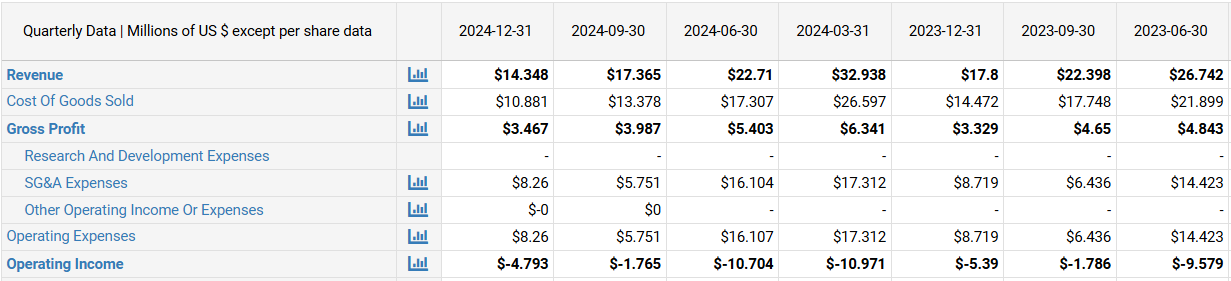

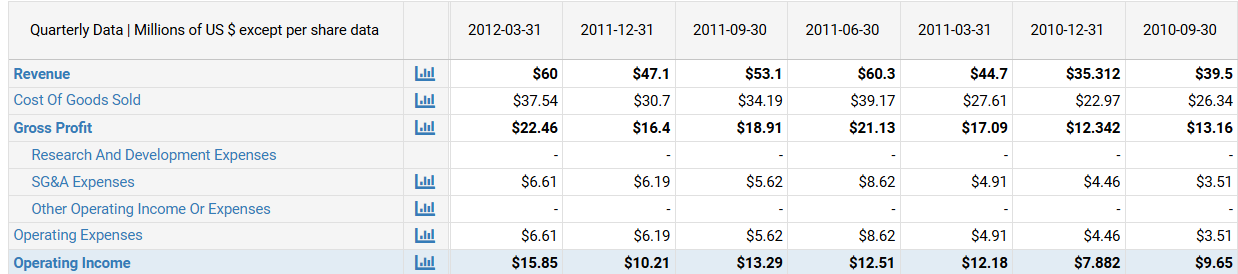


### tables by industry

In [229]:
ag_companies = companies_df[companies_df['industry']==2870]
ag_companies

,cik_str,ticker,title,industry
515,1725964,NTR,Nutrien Ltd.,2870.0
768,1324404,CF,"CF Industries Holdings, Inc.",2870.0
1076,941221,ICL,ICL Group Ltd.,2870.0
1097,1285785,MOS,MOSAIC CO,2870.0
1654,825542,SMG,SCOTTS MIRACLE-GRO CO,2870.0
...,...,...,...,...
6011,875729,BNET,BION ENVIRONMENTAL TECHNOLOGIES INC,2870.0
6030,1574565,EVGN,Evogene Ltd.,2870.0
6324,1789192,NITO,"N2OFF, Inc.",2870.0
6517,1680378,SNES,"SenesTech, Inc.",2870.0


In [281]:
for ticker in ag_companies['ticker']:
    parser = CompanyParser(ticker = ticker, period='annual')
    print(parser.name)
    print(parser.get_table(years=10))

NUTRIEN LTD.
        gross profit  revenue  operating margin  net income
FY2017         694.0   4547.0          0.152628       327.0
FY2018        5392.0  19636.0          0.274598      3573.0
FY2019        5502.0  20084.0          0.273949       992.0
FY2020        5239.0  20908.0          0.250574       459.0
FY2021        9409.0  27712.0          0.339528      3179.0
FY2022       15424.0  37884.0          0.407138      7687.0
FY2023        8474.0  29056.0          0.291644      1282.0
FY2024        7530.0  25972.0          0.289928       700.0
CF INDUSTRIES HOLDINGS, INC.
        gross profit  revenue  operating margin  net income
FY2015        1547.0      NaN               NaN       734.0
FY2016         843.0   3685.0          0.228765      -158.0
FY2017         434.0   4130.0          0.105085       450.0
FY2018         917.0   4429.0          0.207044       428.0
FY2019        1174.0   4590.0          0.255773       646.0
FY2020         801.0   4124.0          0.194229       432.

ValueError: No valid records found for fact 'Revenues' (tried candidates: ['Revenues']) with period type 'annual'.

In [274]:
ticker

'NTR'

### get key metrics

#### revenue growth and operating margin

# edgar tools

https://github.com/dgunning/edgartools/blob/main/docs/quick-guide.md

the base classes are fillings and companies

## get fillings

In [177]:
?get_filings

Signature:
get_filings(
    year: Union[int, List[int], range, NoneType] = None,
    quarter: Union[int, List[int], range, NoneType] = None,
    form: Union[str, List[Union[str, int]], NoneType] = None,
    amendments: bool = True,
    filing_date: Optional[str] = None,
    index='form',
    priority_forms: Optional[List[str]] = None,
) -> Optional[edgar._filings.Filings]
Docstring:
Downloads the filing index for a given year or list of years, and a quarter or list of quarters.

So you can download for 2020, [2020,2021,2022] or range(2020, 2023)

Examples

>>> from edgar import get_filings

>>> filings_ = get_filings(2021) # Get filings for 2021

>>> filings_ = get_filings(2021, 4) # Get filings for 2021 Q4

>>> filings_ = get_filings(2021, [3,4]) # Get filings for 2021 Q3 and Q4

>>> filings_ = get_filings([2020, 2021]) # Get filings for 2020 and 2021

>>> filings_ = get_filings([2020, 2021], 4) # Get filings for Q4 of 2020 and 2021

>>> filings_ = get_filings(range(2010, 2021)) # Get

In [23]:
# 3. Start using the library
filings = get_filings()
filings = filings.filter(date="2015-01-01:")
filings

╭────────────────────────────────────────────────── SEC Filings ──────────────────────────────────────────────────╮
│                                                                                                                 │
│    Form             CIK   Ticker   Company                                  Filing Date   Accession Number      │
│  ─────────────────────────────────────────────────────────────────────────────────────────────────────────────  │
│    10-Q          715446   ANIX     Anixa Biosciences Inc                    2025-03-11    0001493152-25-0098…   │
│    10-Q         1059689            BrightRock Gold Corp                     2025-03-11    0001683168-25-0014…   │
│    10-Q         1059689            BrightRock Gold Corp                     2025-03-11    0001683168-25-0014…   │
│    10-Q          726958   CASY     CASEYS GENERAL STORES INC                2025-03-11    0000726958-25-0000…   │
│    10-Q         1703956   BBCP     Concrete Pumping Holdings, Inc.    

In [26]:
fillings = get_filings(year=range(2015,2026),form='10-Q')

In [31]:
#by cik
ag_filling = fillings.filter(cik=list(ag_companies))
ag_filling

╭────────────────────────────────────────────────── SEC Filings ──────────────────────────────────────────────────╮
│                                                                                                                 │
│    Form             CIK   Ticker   Company                                  Filing Date   Accession Number      │
│  ─────────────────────────────────────────────────────────────────────────────────────────────────────────────  │
│    10-Q          857949   CGA      Enlightify Inc.                          2025-02-24    0001213900-25-0166…   │
│    10-Q          875729   BNET     BION ENVIRONMENTAL TECHNOLOGIES INC      2025-02-14    0001079973-25-0002…   │
│    10-Q          825542   SMG      SCOTTS MIRACLE-GRO CO                    2025-02-05    0001546380-25-0000…   │
│    10-Q         1794276   YCQH     YCQH Agricultural Technology Co. Ltd     2024-11-19    0001493152-24-0466…   │
│    10-Q          875729   BNET     BION ENVIRONMENTAL TECHNOLOGIES INC

## read xbrl
some fillings are xbrl, and there fore can be read: `cga_q_xbrl = ag_filling[0].xbrl()`
and `xbrl.facts` returns the df of facts. 
this can also be used to access the facts or conepts: using the gap names.
can access specific facts: cga_q_xbrl.instance.query_facts(concept="us-gaap:Assets")

to see specific tables use the statements api: `cga_q_xbrl.statements` to see their names 
and `cga_q_xbrl.statements['ConsolidatedIncomeStatement']` to print it

In [145]:
cga_q_xbrl = ag_filling[0].xbrl()
cga_q_xbrl

╭───────────────────────────────────────────────────── XBRL ──────────────────────────────────────────────────────╮
│                      XBRL Instance                                                                              │
│                                                                                                                 │
│   Company            Form   Period              Facts                                                           │
│  ─────────────────────────────────────────────────────                                                          │
│   ENLIGHTIFY, INC.   10-Q   December 31, 2024   781                                                             │
│                                                                                                                 │
│                       Financial Statements                                                                      │
│                                                                       

In [ ]:
ge

In [153]:

cga_q_xbrl.statements['ConsolidatedIncomeStatement']


                                  ENLIGHTIFY, INC.                                  
                                  Income Statement                                  
                                      3 Months                                      
                                                                                    
                                                        Dec 31, 2024  Dec 31, 2023  
 ────────────────────────────────────────────────────────────────────────────────── 
    Revenue from Contract with Customer, Including        14,348,138    17,800,114  
  Assessed Tax                                                                      
    Cost of Goods and Services Sold                     (10,881,359)  (14,471,627)  
  Gross Profit                                             3,466,779     3,328,487  
    Selling Expense                                        1,817,206     1,770,860  
    General and Administrative Expense                     6,442,

In [162]:
get_fact_names(comp_facts,'OperatingIncomeLoss')

['OperatingIncomeLoss', 'SegmentReportingInformationOperatingIncomeLoss']

### edgar tool comapny

In [20]:
company = Company("NTR")


In [27]:
ntr_fil = company.get_filings(form=['40-F','10-K'], date="2015-01-01:")

In [28]:
ntr_fil

╭────────────────────────────────────── Filings for Nutrien Ltd. [1725964] ───────────────────────────────────────╮
│                                                                                                                 │
│   #   Form       Description                                          Filing Date   Accession Number            │
│  ────────────────────────────────────────────────────────────────────────────────────────────────────────       │
│   0   40-F       Annual report (Canadian)                             2025-02-28    0001193125-25-041502        │
│   1   40-F       Annual report (Canadian)                             2024-03-01    0001193125-24-055096        │
│   2   40-F       Annual report (Canadian)                             2023-02-24    0001193125-23-048055        │
│   3   40-F       Annual report (Canadian)                             2022-02-25    0001193125-22-053904        │
│   4   40-F       Annual report (Canadian)                             

In [52]:
ntr_fil[0]

╭──────────────── Form 40-F Nutrien Ltd. [1725964] NTR ─────────────────╮
│                                                                       │
│   Accession Number       Filing Date   Period of Report   Documents   │
│  ───────────────────────────────────────────────────────────────────  │
│   0001193125-25-041502   2025-02-28    2024-12-31         275         │
│                                                                       │
│                                                                       │
│                                                                       │
│                                                                       │
╰────────────────────── Annual report (Canadian) ───────────────────────╯

In [58]:
from edgar.financials import Financials


fin = ntr_fil[0].as_company_filing()

In [68]:
fin.exhibits

                                                 Attachments                                                  
╭─────┬────────────────────┬──────────────────────────────────────────────────────────────┬──────────────────╮
│ Seq │ Document           │ Description                                                  │ Type             │
├─────┼────────────────────┼──────────────────────────────────────────────────────────────┼──────────────────┤
│ 1   │ d795438d40f.htm    │ 40-F                                                         │ 📜  40-F         │
│ 2   │ d795438dex991.htm  │ EX-99.1                                                      │ 📋  EX-99.1      │
│ 3   │ d795438dex992.htm  │ EX-99.2                                                      │ 📋  EX-99.2      │
│ 4   │ d795438dex9921.pdf │ EX-99.2 COURTESY PDF                                         │ 📋  EX-99.2      │
│ 5   │ d795438dex993.htm  │ EX-99.3                                                      │ 📋  EX-99.3      │
│ 6   

In [69]:
tenk_2 = Company("NTR").get_filings(form='40-F').latest(1).obj()
tenk_2

╭───────────────────────────────────────────────────── XBRL ──────────────────────────────────────────────────────╮
│                    XBRL Instance                                                                                │
│                                                                                                                 │
│   Company        Form   Period              Facts                                                               │
│  ─────────────────────────────────────────────────                                                              │
│   NUTRIEN LTD.   40-F   December 31, 2024   2,360                                                               │
│                                                                                                                 │
│                    Financial Statements                                                                         │
│                                                                       

In [83]:
statement_keys = list(tenk_2.statements_dict.keys())

[key for key in statement_keys if 'sheet' in key]

[]

In [84]:
statement_keys

['NotesToFinancialStatementsDisclosureOfDescriptionOfBusinessExplanatory',
 'NotesToFinancialStatementsDisclosureOfBasisOfPreparationOfFinancialStatementsExplanatory',
 'NotesToFinancialStatementsDisclosureOfEntitysReportableSegmentsExplanatory',
 'NotesToFinancialStatementsDisclosureOfExpensesByNatureExplanatory',
 'NotesToFinancialStatementsDisclosureOfSharebasedPaymentArrangementsExplanatory',
 'NotesToFinancialStatementsDisclosureOfOtherOperatingIncomeExpenseExplanatory',
 'NotesToFinancialStatementsDisclosureOfFinanceCostExplanatory',
 'NotesToFinancialStatementsDisclosureOfIncomeTaxExplanatory',
 'NotesToFinancialStatementsDisclosureOfEarningsPerShareExplanatory',
 'NotesToFinancialStatementsDisclosureOfFinancialRiskManagementExplanatory',
 'NotesToFinancialStatementsDisclosureOfTradeAndOtherReceivablesExplanatory',
 'NotesToFinancialStatementsDisclosureOfInventoriesExplanatory',
 'NotesToFinancialStatementsDisclosureOfPropertyPlantAndEquipmentExplanatory',
 'NotesToFinancialStat

In [49]:
tenk = Company("AAPL").get_filings(form="10-K").latest(1)
tenk_2 = Company("AAPL").get_filings(form="10-K").latest(1).obj()

In [50]:
tenk

╭───────────────── Form 10-K Apple Inc. [320193] AAPL ──────────────────╮
│                                                                       │
│   Accession Number       Filing Date   Period of Report   Documents   │
│  ───────────────────────────────────────────────────────────────────  │
│   0000320193-24-000123   2024-11-01    2024-09-28         102         │
│                                                                       │
│                                                                       │
│                                                                       │
│                                                                       │
╰───────────────── Annual report for public companies ──────────────────╯

In [55]:
tenk_2.financials.get_cash_flow_statement().to_dataframe()

,2024,2023,2022
label,,,
"Cash, cash equivalents, and restricted cash and cash equivalents, ending balances",29943000000,30737000000,24977000000
Net income,93736000000,96995000000,99803000000
Depreciation and amortization,11445000000,11519000000,11104000000
Share-based compensation expense,11688000000,10833000000,9038000000
Other,-2266000000,-2227000000,-1006000000
...,...,...,...
"Proceeds from/(Repayments of) commercial paper, net",3960000000,-3978000000,3955000000
Other,-361000000,-581000000,-160000000
Cash used in financing activities,-121983000000,-108488000000,-110749000000


In [ ]:
financials.get_balance_sheet()   

The financials property returns a Financials instance. This instance has methods that return the balance sheet, income statement and cash flow statement.

```
from edgar import MultiFinancials

filings = company.latest("10-K", 5)
financials = MultiFinancials(filings)
```

In [ ]:
ntr_filings = company.latest("10-K", 5)
ntr_filings  = MultiFinancials(ntr_filings)
ntr_filings

In [19]:
df_tickers

,cik_str,ticker,title
0,320193,AAPL,Apple Inc.
1,789019,MSFT,MICROSOFT CORP
2,1045810,NVDA,NVIDIA CORP
3,1018724,AMZN,AMAZON COM INC
4,1652044,GOOGL,Alphabet Inc.
...,...,...,...
9703,1884046,SPKLU,Spark I Acquisition Corp
9704,1884046,SPKLW,Spark I Acquisition Corp
9705,2019804,HONDW,HCM II Acquisition Corp.
9706,2019804,HONDU,HCM II Acquisition Corp.
